In [1]:
#!pwsh
dotnet build C:/Silk.NET/src/Jupyter/Silk.NET.Jupyter/Silk.NET.Jupyter.csproj -v:q | Out-Null

dotnet pack C:/Silk.NET/src/Jupyter/Silk.NET.Jupyter/Silk.NET.Jupyter.csproj /p:PackageVersion=1.1.0 -v:q | Out-Null

In [1]:
#i nuget:C:\Silk.NET\src\Jupyter\Silk.NET.Jupyter\bin\Debug\

#r "nuget:Silk.NET.Jupyter,1.1.0"
#r "nuget:Silk.NET.OpenglES,2.0.0"
#r "nuget:SixLabors.ImageSharp,1.0.2"

Restore sources https://pkgs.dev.azure.com/dnceng/public/_packaging/dotnet-tools/nuget/v3/index.json C:\Silk.NET\src\Jupyter\Silk.NET.Jupyter\bin\Debug\

Installed package Silk.NET.Jupyter version 1.1.0

Installed package SixLabors.ImageSharp version 1.0.2

Installed package Silk.NET.OpenglES version 2.0.0

Loaded Silk.NET.Jupyter.FrameKernel

Silk.NET.Jupyter is loaded. Try it out using var view = JupyterView.Create(100, 100); #!view view

Aquiring View


Creating Buffers


Creating Shader Program


Drawing


Aquiring Frame



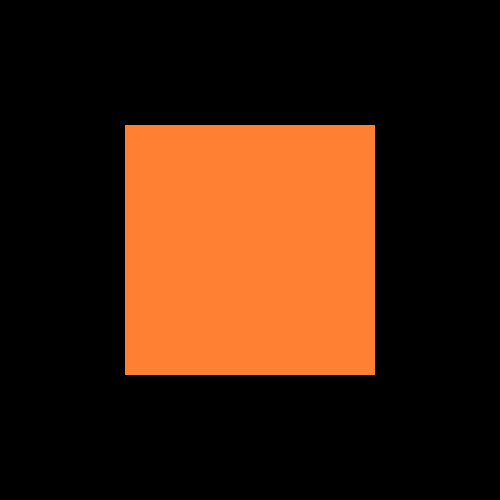

In [1]:
using Silk.NET.Windowing;
using Silk.NET.Jupyter;
using Silk.NET.OpenGLES;

uint Vbo;
uint Ebo;
uint Vao;
uint Shader;

//Vertex shaders are run on each vertex.
string VertexShaderSource = @"#version 300 es //Using version GLSL ES 3.00
layout (location = 0) in vec4 vPos;

void main()
{
    gl_Position = vec4(vPos.x, vPos.y, vPos.z, 1.0);
}
".Replace("\r", "");

//Fragment shaders are run on each fragment/pixel of the geometry.
string FragmentShaderSource = @"#version 300 es
precision mediump float; // medium precision
out vec4 FragColor;

void main()
{
    FragColor = vec4(1.0f, 0.5f, 0.2f, 1.0f);
}
".Replace("\r", "");

//Vertex data, uploaded to the VBO.
float[] Vertices =
{
    //X    Y      Z
    0.5f,  0.5f, 0.0f,
    0.5f, -0.5f, 0.0f,
    -0.5f, -0.5f, 0.0f,
    -0.5f,  0.5f, 0.5f
};

//Index data, uploaded to the EBO.
uint[] Indices =
{
    0, 1, 3,
    1, 2, 3
};

Console.WriteLine("Aquiring View");
var view = JupyterView.Create(500, 500, new GraphicsAPI(ContextAPI.OpenGLES, ContextProfile.Core, ContextFlags.Default, new APIVersion(3, 0)));
view.Initialize();
view.MakeCurrent();
var gl = view.CreateOpenGLES();

unsafe {
    
Console.WriteLine("Creating Buffers");
//Creating a vertex array.
Vao = gl.GenVertexArray();
gl.BindVertexArray(Vao);

//Initializing a vertex buffer that holds the vertex data.
Vbo = gl.GenBuffer(); //Creating the buffer.
gl.BindBuffer(BufferTargetARB.ArrayBuffer, Vbo); //Binding the buffer.
fixed (void* v = &Vertices[0])
{
    gl.BufferData(BufferTargetARB.ArrayBuffer, (nuint) (Vertices.Length * sizeof(uint)), v, BufferUsageARB.StaticDraw); //Setting buffer data.
}

//Initializing a element buffer that holds the index data.
Ebo = gl.GenBuffer(); //Creating the buffer.
gl.BindBuffer(BufferTargetARB.ElementArrayBuffer, Ebo); //Binding the buffer.
fixed (void* i = &Indices[0])
{
    gl.BufferData(BufferTargetARB.ElementArrayBuffer, (nuint) (Indices.Length * sizeof(uint)), i, BufferUsageARB.StaticDraw); //Setting buffer data.
}


Console.WriteLine("Creating Shader Program");
//Creating a vertex shader.
uint vertexShader = gl.CreateShader(ShaderType.VertexShader);
gl.ShaderSource(vertexShader, VertexShaderSource);
gl.CompileShader(vertexShader);

//Checking the shader for compilation errors.
string infoLog = gl.GetShaderInfoLog(vertexShader);
if (!string.IsNullOrWhiteSpace(infoLog))
{
    Console.WriteLine($"Error compiling vertex shader {infoLog}");
}

//Creating a fragment shader.
uint fragmentShader = gl.CreateShader(ShaderType.FragmentShader);
gl.ShaderSource(fragmentShader, FragmentShaderSource);
gl.CompileShader(fragmentShader);

//Checking the shader for compilation errors.
infoLog = gl.GetShaderInfoLog(fragmentShader);
if (!string.IsNullOrWhiteSpace(infoLog))
{
    Console.WriteLine($"Error compiling fragment shader {infoLog}");
}

//Combining the shaders under one shader program.
Shader = gl.CreateProgram();
gl.AttachShader(Shader, vertexShader);
gl.AttachShader(Shader, fragmentShader);
gl.LinkProgram(Shader);

//Checking the linking for errors.
gl.GetProgram(Shader, GLEnum.LinkStatus, out var status);
if (status == 0)
{
    Console.WriteLine($"Error linking shader {gl.GetProgramInfoLog(Shader)}");
}

//Delete the no longer useful individual shaders;
gl.DetachShader(Shader, vertexShader);
gl.DetachShader(Shader, fragmentShader);
gl.DeleteShader(vertexShader);
gl.DeleteShader(fragmentShader);

//Tell opengl how to give the data to the shaders.
gl.VertexAttribPointer(0, 3, VertexAttribPointerType.Float, false, 3 * sizeof(float), null);
gl.EnableVertexAttribArray(0);

// end of setup code
// the following is on-frame code. we only draw one frame
// so for simplicity, here it is:

Console.WriteLine("Drawing");

//Set background (clear) color to SOLID black
gl.ClearColor(0f, 0f, 0f, 1f);

//Clear the color channel.
gl.Clear((uint) ClearBufferMask.ColorBufferBit);

//Bind the geometry and shader.
gl.BindVertexArray(Vao);
gl.UseProgram(Shader);

//Draw the geometry.
gl.DrawElements(PrimitiveType.Triangles, (uint) Indices.Length, DrawElementsType.UnsignedInt, default);
}

Console.WriteLine("Aquiring Frame");
#!frame

gl.Dispose();
view.Dispose();
